# **Explore Text**

In [9]:
import pandas as pd
import sklearn

# leer una tabla .tsv desde github
# df = pd.read_table('https://raw.githubusercontent.com/MAQuesada/sfdat22/master/data/sms.tsv',
#                    sep='\t', header=None, names=['label', 'msg'])
df = pd.read_csv('resources\sms.csv')
df.head()


,label,msg
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


ham     0.865937
spam    0.134063
Name: label, dtype: float64

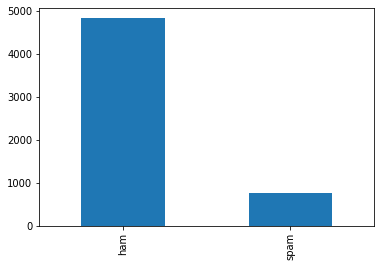

In [10]:
df['label'].value_counts().plot(kind='bar')
df['label'].value_counts()/df.shape[0]


In [11]:
# make all strings lower case so we can search easie
df.msg = df.msg.apply(lambda x: x.lower())

spams = df[df.label == 'spam']  # los mensajes que son spam
for word in ['send', 'cash', 'now']:
    print(f'P( {word}|spam)', spams[spams.msg.str.contains(word)].shape[0]/spams.shape[0])


P( send|spam) 0.0963855421686747
P( cash|spam) 0.09103078982597054
P( now|spam) 0.2797858099062918


In [12]:
from sklearn.feature_extraction.text import CountVectorizer
# virtualizador de conteo de sklearn para convertir texto en datos numericos

# start with a simple example
train_simple = ['call you tonight',
                'Call me a cab',
                'please call me... PLEASE 44!']

# learn the 'vocabulary' of the training data
vect = CountVectorizer()
train_simple_dtm = vect.fit_transform(train_simple)

pd.DataFrame(train_simple_dtm.toarray(), columns=vect.get_feature_names_out())


,44,cab,call,me,please,tonight,you
0,0,0,1,0,0,1,1
1,0,1,1,1,0,0,0
2,1,0,1,1,2,0,0


In [13]:

test_simple = ["please don't call me"]

test_simple_dtm = vect.transform(test_simple)
pd.DataFrame(test_simple_dtm.toarray(), columns=vect.get_feature_names_out())


,44,cab,call,me,please,tonight,you
0,0,0,1,1,1,0,0


Ahora veamos como si añadimos palabras nuevas a nuestro CounterVectorizer, este las ignora. Este es un punto importante e incentiva a los cienticos de datos la mayor cantidad de datos para el entrenamiento

# **MODEL NAIVE BAYES**

In [14]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df.msg, df.label, random_state=123)

# instantiate the vectorizer
vect = CountVectorizer()
# learn vocabulary and create document-term matrix in a single step
train_dtm = vect.fit_transform(x_train)
train_dtm


<4179x7466 sparse matrix of type '<class 'numpy.int64'>'
	with 55283 stored elements in Compressed Sparse Row format>

In [15]:
from sklearn.naive_bayes import MultinomialNB  # import our model

# ajustar nuestros datos de prueba para que se ajusten a nuestro vocabulario
test_dtm = vect.transform(x_test)

nb = MultinomialNB()        # instantiate our model
nb.fit(train_dtm, y_train)  # train a Naive Bayes model using train_dtm


MultinomialNB()

La fase de entremaiento consiste en calcular la probabilidad condicional de cada caracteristica dada cada clase **P( {x_i} | class C )**

La fase de prediccion consiste en calcular la propabilidad posterior para cada clase dadas las caracteristicas observadas **P( class C | {x_i} )**, y entonces decidir la clase con mayor probabilidad

In [16]:
from sklearn import metrics


# make predictions on test data using test_dtm
preds = nb.predict(test_dtm)

# compare predictions to true labels
print(nb.score(test_dtm, y_test))
print(metrics.accuracy_score(y_test, preds))
print('Para saber los Errores de tipo I y tipo II \n ',
      nb.classes_, '\n', metrics.confusion_matrix(y_test, preds))


0.9820531227566404
0.9820531227566404
Para saber los Errores de tipo I y tipo II 
  ['ham' 'spam'] 
 [[1193    8]
 [  17  175]]


Cada fila repesenta los valores reales por lo que podemos decir que tuvimos 8 predicciones falsas de sapm y 17 predicciones falsas de ham   

# **Decision Trees**

In [17]:
titanic = pd.read_csv('resources\short_titanic.csv')         # read in the data

titanic['Sex'] = titanic.Sex.map({'female': 0, 'male': 1})   # encode female as 0 and male as 1

# fill in the missing values for age with the median age
titanic['Age'].fillna(titanic.Age.median(), inplace=True)
titanic.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S


In [18]:
# create a DataFrame of dummy variables for Embarked
embarked_dummies = pd.get_dummies(titanic['Embarked'], prefix='Embarked')
embarked_dummies.head()

# concatenate the original DataFrame and the dummy DataFrame
titanic = pd.concat([titanic, embarked_dummies], axis=1)

# define X and y
feature_cols = ['Pclass', 'Sex', 'Age', 'Embarked_Q', 'Embarked_S']
X = titanic[feature_cols]
y = titanic.Survived

X.head()


,Pclass,Sex,Age,Embarked_Q,Embarked_S
0,3,1,22.0,0,1
1,1,0,38.0,0,0
2,3,0,26.0,0,1
3,1,0,35.0,0,1
4,3,1,35.0,0,1


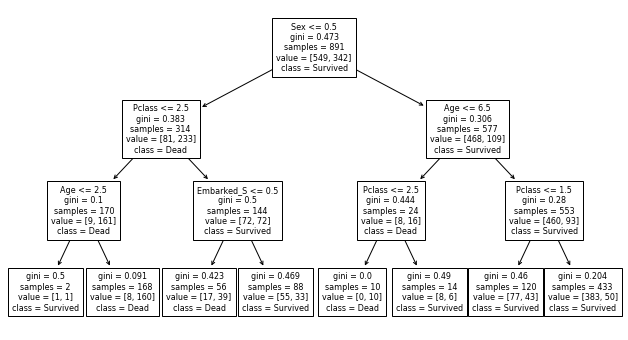

In [19]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# fit a classification tree with max_depth=3 on all data
treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf.fit(X, y)

# show the tree
plt.figure(figsize=(11, 6))
plot_tree(treeclf, feature_names=feature_cols, class_names=['Survived', 'Dead'], fontsize=8)
plt.show()


Podemos notar que :
* El **sex** es la primera division, lo que signifuca que es el factor mas determinante para que una persina sobreviva 
* **Embarked_Q** no se utilizó
>Ahora vamos a obtener el nivel de importancia de cada predictor .


In [20]:
pd.DataFrame({'predictors': feature_cols, 'importance': treeclf.feature_importances_})


,predictors,importance
0,Pclass,0.242664
1,Sex,0.655584
2,Age,0.064494
3,Embarked_Q,0.000000
4,Embarked_S,0.037258


La ***importancia*** es es una diferencia media del indice de Gini  por cada variable. A mayor valor mayor importancia para la prediccón y por eso podemos usar esta informacion para seleccionar menos predictores en el futuro. por ejemplo las dos variables de **Embarked** tienen muy baja importancia en comparacion con el resto de los predictores por lo que podemos decir que no son importantes en nuesrta prediccion de supervivencia


# **Unsupervised Learning: K-means Clustering**

>Intentemos agrupar los distintos tipos de cervezas de acuerdo a sus caracterisicas cuantitativas

In [21]:
# import the beer dataset
url = 'resources/beer.txt'
beer = pd.read_csv(url, sep=' ')
print(beer.shape)
beer.head(3)


(20, 5)


,name,calories,sodium,alcohol,cost
0,Budweiser,144,15,4.7,0.43
1,Schlitz,151,19,4.9,0.43
2,Lowenbrau,157,15,0.9,0.48


In [22]:
from sklearn.cluster import KMeans

# define X
# se elimina la caracteristica nombre pq es cualitativa y no brinda informacion alguna
X = beer.drop('name', axis=1)

km = KMeans(n_clusters=3, random_state=1)
km.fit(X)

# save the cluster labels and sort by cluster
beer['cluster'] = km.labels_
beer.head(3)


,name,calories,sodium,alcohol,cost,cluster
0,Budweiser,144,15,4.7,0.43,0
1,Schlitz,151,19,4.9,0.43,0
2,Lowenbrau,157,15,0.9,0.48,0


In [23]:
beer.groupby('cluster').mean()


,calories,sodium,alcohol,cost
cluster,,,,
0,150.00,17.0,4.521429,0.520714
1,102.75,10.0,4.075000,0.440000
2,70.00,10.5,2.600000,0.420000


como podemos ver las cervezas del cluster 0 tienen mas alcohol mas sodio y mas caloria por lo q cuestan mas(cervezas pesadas), las del cluster 2 tienen pocas calorias y muy bajo nivel de alcohol(cerveza ligeras) y las del cluster uno son un termini medio.
> intentemos ver eso visualmente 

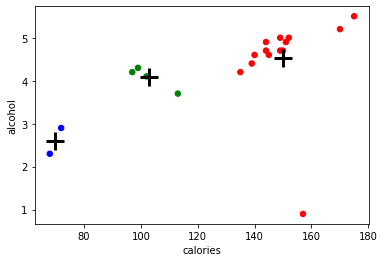

In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# save the DataFrame of cluster centers
centers = beer.groupby('cluster').mean()
# create a "colors" array for plotting
colors = np.array(['red', 'green', 'blue', 'yellow'])

# scatter plot of calories versus alcohol, colored by cluster (0=red,1=green, 2=blue)
plt.scatter(beer.calories, beer.alcohol, c=colors[list(beer.cluster)], s=30)
# cluster centers, marked by "+"
plt.scatter(centers.calories, centers.alcohol, linewidths=3,
            marker='+', s=300, c='black')
# add labels
plt.xlabel('calories')
plt.ylabel('alcohol')

plt.show()


> **Una gran parte del aprendizaje no supervisado es la inspeccion humana, pq el *CLUSTERING* no tiene dominio del problema y no puede decirnos que significa cada cluster que encontró**

0.6731775046455796


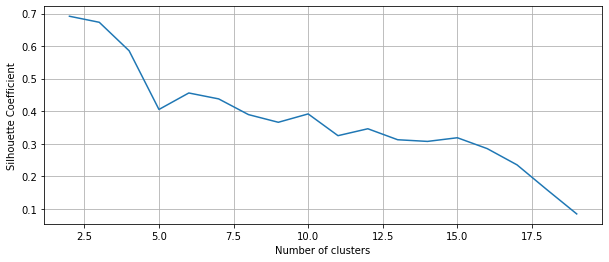

In [25]:
# calculate Silhouette Coefficient

from sklearn import metrics
print(metrics.silhouette_score(X, km.labels_))

# calculate SC for K=2 through K=19
k_range = range(2, 20)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X)
    scores.append(metrics.silhouette_score(X, km.labels_))
# plot the results
plt.figure(figsize=(10, 4))
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)



Parece que el número número óptimo de clusters es 2,y por lo tanto dos tipos de cerveza

# **Course of Dimensionality**

In [26]:
df.count()

# instantiate the vectorizer
vect = CountVectorizer()
# learn vocabulary and create document-term matrix in a single step
train_dtm = vect.fit_transform(df['msg'])
X = train_dtm[:4086, :]
X.shape


(4086, 8713)

Ahora se realizará un experimiento con los mensajes en el DataFrame **df** que al vectorizarlo obtenemos 4086 filas y 8713. Primero se considerará una sola palabra como la unica dimensión de nuestro texto. A continuacion se contara cuantos trozos de texto estan a menos de una unidad de nuestro texto.. Por ejemplo si dos frases contienen ambas esa palabra estarian a distancia cero y del mismo modo si no ninguna de las dos contiene la palabra, estarían a 0 unidades de distancia de la otra;es decir que va a ser mayor que una unidad si uno de los dos posee la caracteristica y el otro no. Para dimensiones mayores ocurre lo mismo **la distacia va a ser menos que que uno solo si ambas filas tienen las mismas caracterirsticas**

Y para calcular las distancias entre vecinos utilizaremos 

### **NearestNeighbors**: Aprendizaje no supervisado para implementar búsquedas de vecinos

Tenemos 16,695,396 = (4086*4086) distancias por analizar pq cada punto tambien se le calcula la distancia con el mismo que es cero

In [27]:
from sklearn.neighbors import NearestNeighbors
# this module will calculate for us distances between each point

d = 1  # Let's look for points within 1 unit of one another

# Only looking at the first column, but ALL of the rows
X_first_word = X[:, :1]


# inicializar el modelo con 4086 puntos para calcular la distacia entre cada par de puntos
neigh = NearestNeighbors(n_neighbors=4086)

# indicar al modelo que calcule cada distancia entre los puntos
neigh.fit(X_first_word)
# matrix in Compressed Sparse Row format with the all distance (4086 x 4086)
A = neigh.kneighbors_graph(X_first_word, mode='distance')

# Para obtener una matriz de NumPy
A = A.todense()

(A < d).sum()  # Count the number of pairs of points within 1 unit of distance


16613876

Es decir que 16.6 millones de pares de datos se encuentran a una sola unidad de distancia. Ahora calculemos ese mismo numero desde dos columnas hasta 100

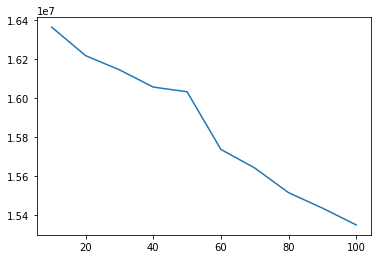

In [28]:
points = []
num_column = np.array(range(1, 11))*10

# We will be collecting the number of points within 1 unit for a graph
neigh = NearestNeighbors(n_neighbors=X.shape[0])
for subset in num_column:
    X_subset = X[:, :subset]
    neigh.fit(X_subset)
    A = neigh.kneighbors_graph(X_subset, mode='distance').todense()
    points.append((A < d).sum())

plt.plot(num_column, points)
plt.show()


Se puede apreciar que el número de puntos que se encuentran a una unidad de distancia(tienen las mismas caracteristicas) disminuye drásticamnete a medida introducimos más y más columnas. La grafica muestra solo las primeras 100 columnas, pero si utilizaramos todas las columnas (8713) obtendriamos solo 5460 puntos a una unidad de distancia. Y precisamente todo ese espacio que añadimos al considerar nuevas columnas hace más dificil que la cantidad finita de puntos que tenemos se mantenga dentro del rango de cada uno. Para contrarestar eso tendríamos que añadir más puntos (lo que siempre no es posible) y por eso es que tenemos que usar la **dimension reduction**

# **Unsupervised Learning: Principal Component Analysis(PCA)**

In [29]:
url = 'resources\yelp.csv'
yelp = pd.read_csv(url, encoding='unicode-escape')

yelp_best_worst = yelp[(yelp.stars == 5) | (yelp.stars == 1)]

# define X and y
X = yelp_best_worst.text
y = yelp_best_worst.stars == 5

pd.DataFrame({'text':X,'five_stars':y}).head()


,text,five_stars
0,My wife took me here on my birthday for breakf...,True
1,I have no idea why some people give bad review...,True
3,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",True
4,General Manager Scott Petello is a good egg!!!...,True
6,Drop what you're doing and drive here. After I...,True


Nuestro objetivo es predecir si una persona ha dado una reseña de 5 o 1 estrella basandose en las palabras de la reseña. Hagmos una **Regresión Lógistica** para ver que tan bien podemos predecir. 

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)

# Count the number of words but remove stop words like a, an, the,you, etc
vect = CountVectorizer(stop_words='english')

X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)


# fit to our training set
lr.fit(X_train_dtm, y_train)

lr.score(X_test_dtm,y_test)

0.9119373776908023

Usando todas las palabras nuestro modelos tiene una precisión del 91% que no esata nada mal. Ahora se vera cuando usemos solo 10 palabras

In [31]:
vect = CountVectorizer(stop_words='english', max_features=100)

X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)


# fit to our training set
lr.fit(X_train_dtm, y_train)

lr.score(X_test_dtm, y_test)


0.8816046966731899

Con solo 100 columnas de palabras(debido al que se le dijo al vectorizador que solo mirara 100 palabras) se ha bajado a un 88% de precisión, lo que tiene mucho sentido pq hemos eliminado ams de 4700 columnas.

Ahora vamos a usar **PCA** y crear 100 nuevas super columnas

In [32]:
from sklearn import decomposition

vect = CountVectorizer(stop_words='english')

# instantate a pca object
pca = decomposition.PCA(n_components=100)

# A dense matrix is required to pass into PCA, does not affect the overall message
X_train_dtm = vect.fit_transform(X_train).todense()

X_train_dtm = pca.fit_transform(X_train_dtm)
X_test_dtm = vect.transform(X_test).todense()
X_test_dtm = pca.transform(X_test_dtm)

print(X_test_dtm.shape)  # (1022, 100)

lr.fit(X_train_dtm, y_train)
lr.score(X_test_dtm, y_test)


c:\Users\Manue!_PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\Manue!_PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


(1022, 100)


0.8953033268101761

Nuestras matrices siguen teniendo 100 columnas pero ya cada columna no es una palabra de nuestro cropus, son transformaciones complejas para obtener 100 columnas nuevas.Y el uso de estas 100 super-columnas nos mejora el rendimiento predictivo 

In [ ]:
from sklearn.datasets import fetch_lfw_people

	
# Cargue el conjunto de datos de rostros etiquetados en estado salvaje (LFW).
# solo se cargaran imágenes de personas que tengan al menos 70 imágenes diferentes.
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
# n_samples, h, w = lfw_people.images.shape

lfw_people.data.shape
# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
# X = lfw_people.data
# y = lfw_people.target
